In [1]:
#import packages
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, roc_auc_score, roc_curve
from sklearn.datasets import make_regression

In [2]:
#import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/jackepstein/Documents/GitHub/wildfires-1001/code/functions/')
data_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/data'
code_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/code'

# Pull in main data frame

In [3]:
#pull in the target data frame and weather dictionary 
#make sure to change the pkl file name if needed
target_dict = {}
target_df = gpd.GeoDataFrame()
for i in np.arange(1, 3):
    target_dict[i] = pd.read_pickle(os.path.join(data_dir, f'clean_data/target_df_final_1123_newtargets_{i}.pkl')) 
    target_df = target_df.append(target_dict[i])


weather_dict_path = os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl')

In [4]:
#load the naming dictionary
with open(weather_dict_path, 'rb') as handle:
    rename_dict = pickle.load(handle)

In [5]:
#rename the columns based on this dictionary
target_df.rename(columns = rename_dict, inplace = True)

In [6]:
#create lists of columns to drop and what our targets are
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','NAME','GRID_AREA','COUNTY_ARE','COUNTY_AREA',
                'geometry', 'adj_fire_count','adj_fire_bcount', 'Fire_area','Index','index']
bad_features = ['hist_p_time_1m', 'total_fire_days', 'hist_p_time_1y','month_id_old']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

In [7]:
#convert floats from 64 to 32 for model
for col in target_df.columns:
    if target_df[col].dtypes == 'float64':
        target_df[col] = target_df[col].astype(np.float32)

# Split training and testing data

In [8]:
#generate training data set
#pre 2016
train_data = target_df[target_df['YEAR']<=2016]
X_train = train_data.drop('YEAR', axis = 1)
#drop columns not used for modeling
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train_reg = train_data[['Y_fire_area_prop']]
Y_train_cl = train_data[['Y_bin_new_fire_month']]
Y_train_cl_size = train_data[['Y_max_new_fire_size_month']]

#generate testing data set - same logic as above
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_reg = test_data[['Y_fire_area_prop']]
Y_test_cl = test_data[['Y_bin_new_fire_month']]
Y_test_cl_size = test_data[['Y_max_new_fire_size_month']]

In [9]:
#check for any null values

#null vals array
null = np.zeros(len(X_train.columns))

for i in range(len(X_train.columns)):
    null[i] = X_train.loc[X_train[X_train.columns[i]].isna()].shape[0]
    
np.sum(null)

0.0

# Build OOB Random Forest - Class

In [19]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,Y_train_cl.to_numpy().ravel())

RandomForestClassifier()

In [20]:
y_test_cl_arr = Y_test_cl.to_numpy()
preds_clf = rf_clf.predict(X_test)

#plot confusion
confusion_matrix(y_test_cl_arr, preds_clf)

#get precision and recall scores
print(classification_report(y_test_cl_arr, preds_clf))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4176
           1       0.58      0.20      0.30       576

    accuracy                           0.89      4752
   macro avg       0.74      0.59      0.62      4752
weighted avg       0.86      0.89      0.86      4752



In [21]:
#check feature importance 
features_clf = pd.DataFrame()
features_clf['feature'] = X_test.columns
features_clf['feature score'] = rf_clf.feature_importances_
features_clf.sort_values(by=['feature score'], ascending=False)

,feature,feature score
121,2m_tmp_18hrs_5y,0.015581
70,tot_area_fire_prev_1yr,0.014893
66,hist_fire_area_prop_1m,0.013501
153,2m_tmp_18hrs_10y,0.013477
67,hist_fire_area_prop_1y,0.012678
...,...,...
97,leaf_low_veg_18hrs_1y,0.001716
4,elev_min,0.001713
27,medianHHI2018,0.001610
2,elev_media,0.001538


# Try Clf only during fire season

In [10]:
#try doing only on months in fire season
#pick may - november
fire_season = target_df.loc[target_df['MONTH']>=5].loc[target_df['MONTH']<=11]

In [11]:
#generate training data set - on fire season
#pre 2016
train_data_v2 = fire_season[fire_season['YEAR']<=2016]
X_train_v2 = train_data_v2.drop('YEAR', axis = 1)
#drop columns not used for modeling
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train_v2.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train_cl_v2 = train_data_v2[['Y_bin_new_fire_month']]

#generate testing data set - same logic as above
test_data_v2 = fire_season[fire_season['YEAR']>2016]
X_test_v2 = test_data_v2.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test_v2.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_cl_v2 = test_data_v2[['Y_bin_new_fire_month']]

In [12]:
#oob Random forest
rf_clf_2 = RandomForestClassifier()
rf_clf_2.fit(X_train_v2,Y_train_cl_v2.to_numpy().ravel())

RandomForestClassifier()

In [13]:
y_test_cl_arr_2 = Y_test_cl_v2.to_numpy()
preds_clf_2 = rf_clf_2.predict(X_test_v2)

#plot confusion
print(confusion_matrix(y_test_cl_arr_2, preds_clf_2))
print(roc_auc_score(y_test_cl_arr_2, preds_clf_2))
print(classification_report(y_test_cl_arr_2, preds_clf_2))

[[2158   97]
 [ 386  131]]
0.6051846959475398
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2255
           1       0.57      0.25      0.35       517

    accuracy                           0.83      2772
   macro avg       0.71      0.61      0.63      2772
weighted avg       0.80      0.83      0.80      2772



In [14]:
features_clf2 = pd.DataFrame()
features_clf2['feature'] = X_test.columns
features_clf2['feature score'] = rf_clf_2.feature_importances_
features_clf2.sort_values(by=['feature score'], ascending=False)

,feature,feature score
70,tot_area_fire_prev_1yr,0.018070
67,hist_fire_area_prop_1y,0.015124
66,hist_fire_area_prop_1m,0.014588
73,hist_prop_area_fire_1m,0.012640
118,2m_tmp_0hrs_5y,0.011609
...,...,...
95,leaf_low_veg_6hrs_1y,0.001955
27,medianHHI2018,0.001599
62,hist_bin_10y,0.001469
4,elev_min,0.001399


# Limit to Positive Instances and Predict Class Size

In [15]:
#limit to positives 
pos_df = target_df.loc[target_df['Y_bin_new_fire_month']==1]

#generate training data set
#pre 2016
train_data_pos = pos_df[pos_df['YEAR']<=2016]
X_train_pos = train_data_pos.drop('YEAR', axis = 1)
#drop columns not used for modeling
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train_pos.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train_cl_size_pos = train_data_pos[['Y_max_new_fire_size_month']]

#generate testing data set - same logic as above
test_data_pos = pos_df[pos_df['YEAR']>2016]
X_test_pos = test_data_pos.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test_pos.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_cl_size_pos = test_data_pos[['Y_max_new_fire_size_month']]

In [16]:
#oob Random forest
y_size_pos = Y_train_cl_size_pos.to_numpy().ravel()
rf_clf_size = RandomForestClassifier()
rf_clf_size.fit(X_train_pos,y_size_pos)

RandomForestClassifier()

In [18]:
preds_clf_pos = rf_clf_size.predict(X_test_pos)
y_size_pos_test = Y_test_cl_size_pos.to_numpy().ravel()

#plot confusion
print(confusion_matrix(y_size_pos_test, preds_clf_pos))

print(classification_report(y_size_pos_test, preds_clf_pos))

[[199  51  48]
 [ 56  28  33]
 [ 72  27  62]]
              precision    recall  f1-score   support

           1       0.61      0.67      0.64       298
           2       0.26      0.24      0.25       117
           3       0.43      0.39      0.41       161

    accuracy                           0.50       576
   macro avg       0.44      0.43      0.43       576
weighted avg       0.49      0.50      0.49       576



# Build OOB RF - Regression

In [22]:
#fit the regression model
rf = RandomForestRegressor()
rf.fit(X_train,Y_train_reg.to_numpy().ravel())

RandomForestRegressor()

In [24]:
#turn y and prediction into arrays
preds_arrays = rf.predict(X_test)
y_test_arr = Y_test_reg.to_numpy()

R^2 value: 0.45001813151031966


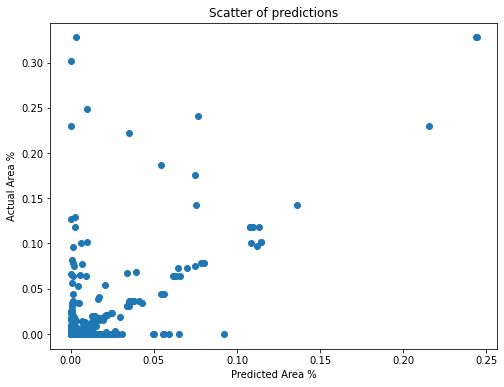

In [26]:
#plot predictions vs actuals
plt.figure(figsize=(8,6))
plt.scatter(preds_arrays, y_test_arr)
plt.title('Scatter of predictions')
plt.xlabel('Predicted Area %')
plt.ylabel('Actual Area %')
#check R^2 value
print("R^2 value:",rf.score(X_test, Y_test_reg))
plt.show()

In [27]:
features = pd.DataFrame()
features['feature'] = X_test.columns
features['feature_score'] = rf.feature_importances_
features.sort_values(by='feature_score', ascending=False)

,feature,feature_score
73,hist_prop_area_fire_1m,4.342618e-01
72,hist_cl_size_no_leak_1m,1.146312e-01
66,hist_fire_area_prop_1m,1.865205e-02
121,2m_tmp_18hrs_5y,1.437407e-02
47,2m_tmp_12hrs,9.060250e-03
...,...,...
97,leaf_low_veg_18hrs_1y,3.510070e-04
71,hist_bin_no_leak_1m,1.949293e-04
60,hist_bin_1y,5.421005e-05
61,hist_bin_5y,7.347610e-06
